In [16]:
using Plots
include("coevolution_network_base.jl")
using .CoevolutionNetworkBase
using Printf
theme(:dracula)

In [17]:
# Parameters
L = 40.0
dx = 0.05
x = -L/2:dx:L/2-dx
r = 3.0
M = 15
beta = 2.5
alpha = 0.0
gamma = 1.0
# D = 0.0025
D = 0.01
Nh = 2 * 10^6
stochastic = true
sigma = 1.0

# Initialize viral and immune densities
viral_density = zeros(Float64, length(x))
viral_density[Int(round(length(x)/2))] = 100/dx

# initial_variance = 0.3
# viral_density .= 100/sqrt(2 * pi * initial_variance) .* exp.(-x.^2/2/initial_variance)
viral_density2 = zeros(Float64, length(x))
immune_density = zeros(Float64, length(x))

# Create Population instances
population = Population(L, dx, r, M, beta, alpha, gamma, D, Nh, viral_density, immune_density;stochastic=stochastic, sigma=sigma)
population2 = Population(L, dx, r, M, beta, alpha, gamma, D, Nh, viral_density2, immune_density; stochastic=stochastic, sigma=sigma)
populations = [population, population2]

# populations[1] = Population(L, dx, r, M, beta, alpha, gamma, D, Nh, viral_density, immune_density;stochastic=true)

# Create Network instance
migration_matrix = 1e-1 * ones(size(populations,1),size(populations,1)) # Define an appropriate migration matrix
println(size(migration_matrix,1))
network = Network(populations, migration_matrix);

# Create Simulation instance
dt = 0.05 # Define an appropriate time step size
duration = 80.0 # Define an appropriate simulation duration
simulation = Simulation(network, dt, duration; thin_by=1);

@time run_simulation!(simulation);

total_infected_per_deme = calculate_total_infected_per_deme(simulation)
println(total_infected_per_deme[1,end] > 0)

2
  0.534858 seconds (3.20 k allocations: 19.934 MiB)
true


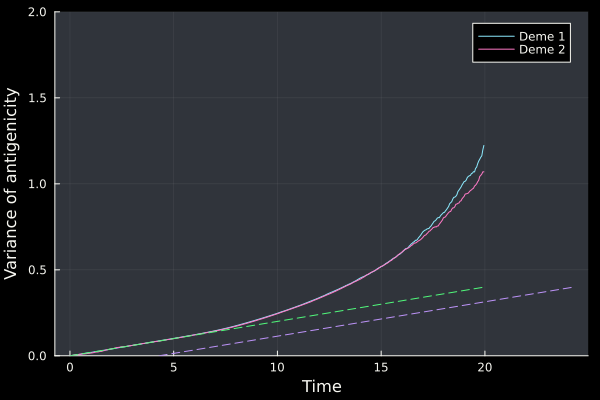

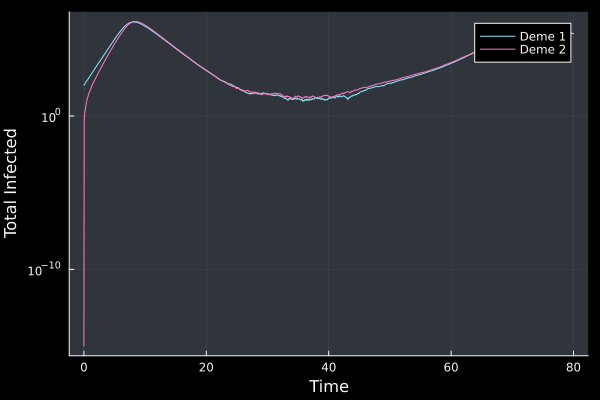

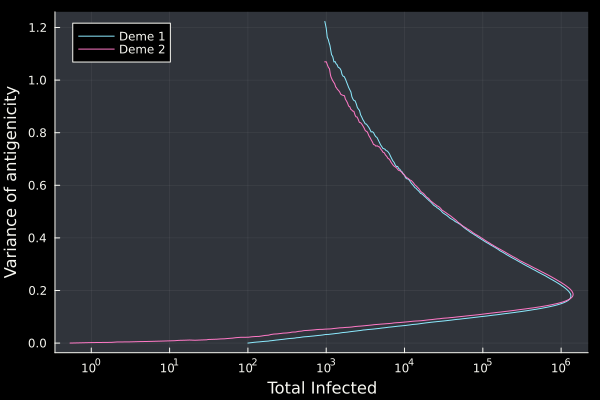

In [18]:
variances_per_deme = calculate_antigenic_variance_per_deme(simulation)
total_infected_per_deme = calculate_total_infected_per_deme(simulation)

# Number of demes
num_demes = size(total_infected_per_deme, 1)

# Plot for Variance of Antigenicity vs Time
treg = simulation.duration_times .< 20
p = plot(;xlabel="Time", ylabel="Variance of antigenicity", background_color=:black)
p2 = plot(xlabel="Time", ylabel="Total Infected", background_color=:black, yscale=:log, legend=:best)
p3 = plot(xlabel="Total Infected", ylabel="Variance of antigenicity", xscale=:log10, legend=:topleft, background_color=:black)


for deme in 1:num_demes
    plot!(p, simulation.duration_times[treg], variances_per_deme[deme, treg], label="Deme $deme")
end
plot!(p, simulation.duration_times[treg], 0 .+ 2 * D * simulation.duration_times[treg], linestyle=:dash, label=:none)
plot!(p, simulation.duration_times[treg] .+ 4.3, 2 * D * simulation.duration_times[treg], linestyle=:dash, label=:none)
plot!(p, ylim=(0,2))
display(p)

# Plot for Total Infected vs Time
treg = simulation.duration_times .< 90

# Manually setting y-axis ticks for each order of magnitude
# yticks = [10^i for i in 0:7]; plot!(p2, yticks=yticks)
for deme in 1:num_demes
    plot!(p2, simulation.duration_times[treg], total_infected_per_deme[deme, treg] .+ 10^-15, label="Deme $deme")
end
# plot!(p2, simulation.duration_times[treg] .- 4.3, total_infected_per_deme[2, treg] .+ 10^-15, label="Deme 2, shifted", xlim=(0,Inf))
display(p2)

for deme in 1:num_demes
    # Find the index where the total infected per deme attains its maximum for the first time
    max_index = findfirst(==(maximum(total_infected_per_deme[deme, :])), total_infected_per_deme[deme, :])

    # Create the Boolean mask
    # reg = (total_infected_per_deme[deme, :] .> 100) .& (variances_per_deme[deme, :] .> 0) .& (1:length(total_infected_per_deme[deme, :]) .< max_index)
    reg = (total_infected_per_deme[deme, :] .> 0) .& (simulation.duration_times .<  simulation.duration_times[argmax(total_infected_per_deme[deme, 1:50])])
    reg = (total_infected_per_deme[deme, :] .> 0) .& (simulation.duration_times .<  20)
    # Plot using the mask
    plot!(p3, total_infected_per_deme[deme, reg], variances_per_deme[deme, reg], label="Deme $deme")
end
display(p3)

In [19]:
# anim = Plots.@animate for i in 1:length(simulation.duration_times)
#     # Create the primary plot
#     p = plot(yscale=:log10, ylims=(1,3*Nh), xlims=(-L/2, L/2), xlabel="Antigenic Coordinate x", ylabel="Infected Density n(x,t)", background_color=:black)

#     for j in 1:2
#         reg = simulation.trajectory[i].populations[j].viral_density .> 0
#         temp_dens = copy(simulation.trajectory[i].populations[j].viral_density)
#         temp_dens[.!reg] .= NaN
#         # plot!(p, population.xs, temp_dens, linetype=:steppre, label="Deme $j")
#         scatter!(p, population.xs, temp_dens, label="Deme $j")
#     end

#     # Create and update the secondary y-axis for fitnesses
#     p3 = twinx(p)

#     for j in 1:2
#         plot!(p3, simulation.trajectory[i].populations[j].xs, simulation.trajectory[i].populations[j].fitness, ylims=(-1,1.5))
#     end
#     hline!(p3, [0], linestyle=:dash, color=:white, label=:none)

# end
# mp4(anim, "dummy_file.mp4", fps = 60)


Testing the diffusion 

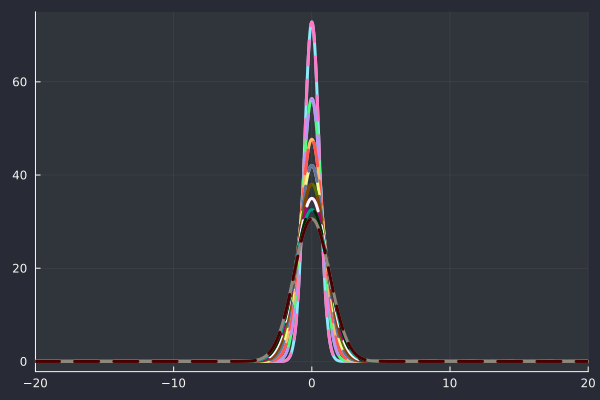

  0.161995 seconds (1.60 k allocations: 9.962 MiB)
true


In [20]:
# Parameters
L = 40.0
dx = 0.05
x = -L/2:dx:L/2-dx
r = 2.5
M = 15
beta = 0.0
alpha = 0.0
gamma = 0.0
# D = 0.0025
D = 0.01
Nh = 2 * 10^6
stochastic = false
sigma = 1.0

# Initialize viral and immune densities
viral_density = zeros(Float64, length(x))
viral_density[Int(round(length(x)/2))] = 100/dx

initial_variance = 0.3
viral_density .= 100/sqrt(2 * pi * initial_variance) .* exp.(-x.^2/2/initial_variance)
immune_density = zeros(Float64, length(x))

# Create Population instances
population = Population(L, dx, r, M, beta, alpha, gamma, D, Nh, viral_density, immune_density;stochastic=stochastic, sigma=sigma)
populations = [population]

# populations[1] = Population(L, dx, r, M, beta, alpha, gamma, D, Nh, viral_density, immune_density;stochastic=true)

# Create Network instance
migration_matrix = 0.0 * ones(size(populations,1),size(populations,1)) # Define an appropriate migration matrix
network = Network(populations, migration_matrix);

# Create Simulation instance
dt = 0.05 # Define an appropriate time step size
duration = 80.0 # Define an appropriate simulation duration
simulation = Simulation(network, dt, duration; thin_by=20);

@time run_simulation!(simulation);

total_infected_per_deme = calculate_total_infected_per_deme(simulation)
println(total_infected_per_deme[1,end] > 0)

p = plot(legend=false)
for t_idx = 1:10:80
    curr_var = initial_variance + 2 * D * simulation.duration_times[t_idx]
    plot!(p, x, simulation.trajectory[t_idx].populations[1].viral_density, xlim=(-20,20), lw=3)
    plot!(p, x, 100 / sqrt(2 * pi * curr_var) .* exp.(-x.^2 /2/curr_var), linestyle=:dash, lw=3)
end
display(p)

Testing the dynamics

  0.013573 seconds (8.00 k allocations: 3.785 MiB)
  0.087989 seconds (8.00 k allocations: 5.616 MiB)
  0.628166 seconds (8.00 k allocations: 25.391 MiB)
  1.148490 seconds (8.00 k allocations: 49.805 MiB)
  7.904872 seconds (8.00 k allocations: 82.520 MiB)


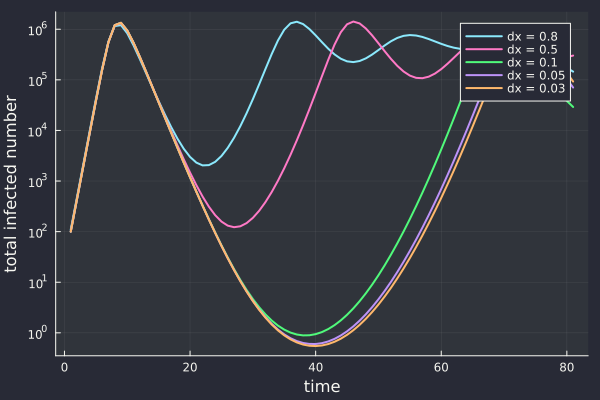

In [21]:
dx_values = [0.8, 0.5, 0.1, 0.05, 0.03]

p = plot(xlabel = "time", ylabel="total infected number", yscale=:log10)
for i in eachindex(dx_values)      
    # Parameters
    L = 40.0
    dx = dx_values[i]
    x = -L/2:dx:L/2-dx
    r = 2.5
    M = 15
    beta = 2.5
    alpha = 0.0
    gamma = 1.0
    D = 0.0025
    # D = 0.01
    Nh = 2 * 10^6
    stochastic = false
    sigma = 1.0

    # Initialize viral and immune densities
    viral_density = zeros(Float64, length(x))
    # viral_density[Int(round(length(x)/2))] = 100/dx

    initial_variance = 0.1
    viral_density .= 100/sqrt(2 * pi * initial_variance) .* exp.(-x.^2/2/initial_variance)
    immune_density = zeros(Float64, length(x))

    # Create Population instances
    population = Population(L, dx, r, M, beta, alpha, gamma, D, Nh, viral_density, immune_density;stochastic=stochastic, sigma=sigma)
    populations = [population]

    # populations[1] = Population(L, dx, r, M, beta, alpha, gamma, D, Nh, viral_density, immune_density;stochastic=true)

    # Create Network instance
    migration_matrix = 0.0 * ones(size(populations,1),size(populations,1)) # Define an appropriate migration matrix
    network = Network(populations, migration_matrix);

    # Create Simulation instance
    dt = 0.01 # Define an appropriate time step size
    duration = 80.0 # Define an appropriate simulation duration
    simulation = Simulation(network, dt, duration; thin_by=100);

    @time run_simulation!(simulation);

    total_infected_per_deme = calculate_total_infected_per_deme(simulation)
    plot!(p, total_infected_per_deme[1,:], lw=2, label="dx = $(dx)")
end
display(p)

it seems like dx = 0.1 is pretty converged, this can be checked in the no diffusion case which should look like SIR

CFL:0.0
  0.066232 seconds (8.00 k allocations: 3.787 MiB)
CFL:0.0
  0.097086 seconds (8.00 k allocations: 5.618 MiB)
CFL:0.0
  0.436070 seconds (8.00 k allocations: 25.394 MiB)
CFL:0.0
  7.700943 seconds (8.00 k allocations: 82.523 MiB, 1.46% gc time)


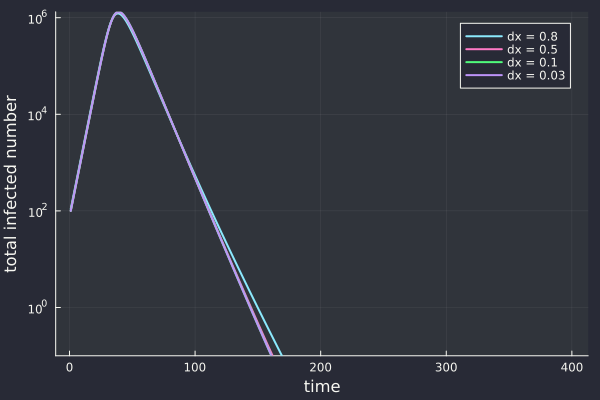

In [22]:
dx_values = [0.8, 0.5, 0.1, 0.03]

p2 = plot(xlabel = "time", ylabel="total infected number", yscale=:log10, ylim=(0.1, Inf))
for i in eachindex(dx_values)      
    # Parameters
    L = 40.0
    dx = dx_values[i]
    x = -L/2:dx:L/2-dx
    r = 3.0
    M = 15
    beta = 2.5
    alpha = 0.0
    gamma = 1.0
    # D = 0.0025
    D = 0.0
    Nh = 2 * 10^6
    stochastic = false
    sigma = 1.0

    # Initialize viral and immune densities
    viral_density = zeros(Float64, length(x))
    # viral_density[Int(round(length(x)/2))] = 100/dx

    initial_variance = 0.1
    viral_density .= 100/sqrt(2 * pi * initial_variance) .* exp.(-x.^2/2/initial_variance)
    immune_density = zeros(Float64, length(x))

    # Create Population instances
    population = Population(L, dx, r, M, beta, alpha, gamma, D, Nh, viral_density, immune_density;stochastic=stochastic, sigma=sigma)
    populations = [population]

    # populations[1] = Population(L, dx, r, M, beta, alpha, gamma, D, Nh, viral_density, immune_density;stochastic=true)

    # Create Network instance
    migration_matrix = 0.0 * ones(size(populations,1),size(populations,1)) # Define an appropriate migration matrix
    network = Network(populations, migration_matrix);

    # Create Simulation instance
    dt = 0.01 # Define an appropriate time step size
    duration = 80.0 # Define an appropriate simulation duration
    simulation = Simulation(network, dt, duration; thin_by=20);

    println("CFL:", D * dt / dx^2)
    @time run_simulation!(simulation);
    total_infected_per_deme = calculate_total_infected_per_deme(simulation)
    plot!(p2, total_infected_per_deme[1,:], lw=2, label="dx = $(dx)")
end
display(p2)

Now with noise

CFL:0.0
  0.043837 seconds (8.00 k allocations: 3.787 MiB)
CFL:0.0
  0.113305 seconds (8.00 k allocations: 5.618 MiB)
CFL:0.0
  0.538110 seconds (8.00 k allocations: 25.394 MiB)


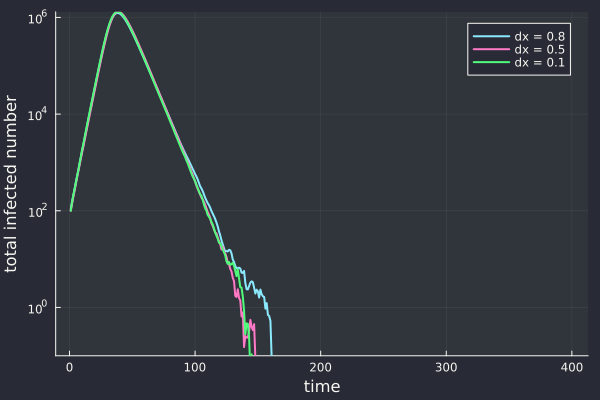

In [23]:
dx_values = [0.8, 0.5, 0.1]

p2 = plot(xlabel = "time", ylabel="total infected number", yscale=:log10, ylim=(0.1, Inf))
for i in eachindex(dx_values)      
    # Parameters
    L = 40.0
    dx = dx_values[i]
    x = -L/2:dx:L/2-dx
    r = 3.0
    M = 15
    beta = 2.5
    alpha = 0.0
    gamma = 1.0
    # D = 0.0025
    D = 0.0
    Nh = 2 * 10^6
    stochastic = true
    sigma = 1.0

    # Initialize viral and immune densities
    viral_density = zeros(Float64, length(x))
    # viral_density[Int(round(length(x)/2))] = 100/dx

    initial_variance = 0.1
    viral_density .= 100/sqrt(2 * pi * initial_variance) .* exp.(-x.^2/2/initial_variance)
    immune_density = zeros(Float64, length(x))

    # Create Population instances
    population = Population(L, dx, r, M, beta, alpha, gamma, D, Nh, viral_density, immune_density;stochastic=stochastic, sigma=sigma)
    populations = [population]

    # populations[1] = Population(L, dx, r, M, beta, alpha, gamma, D, Nh, viral_density, immune_density;stochastic=true)

    # Create Network instance
    migration_matrix = 0.0 * ones(size(populations,1),size(populations,1)) # Define an appropriate migration matrix
    network = Network(populations, migration_matrix);

    # Create Simulation instance
    dt = 0.01 # Define an appropriate time step size
    duration = 80.0 # Define an appropriate simulation duration
    simulation = Simulation(network, dt, duration; thin_by=20);

    println("CFL:", D * dt / dx^2)
    @time run_simulation!(simulation);
    total_infected_per_deme = calculate_total_infected_per_deme(simulation)
    plot!(p2, total_infected_per_deme[1,:], lw=2, label="dx = $(dx)")
end
display(p2)

Now with noise and diffusion 

CFL:3.9062499999999994e-5
  0.104673 seconds (8.00 k allocations: 3.787 MiB)
CFL:0.0001
  0.122990 seconds (8.00 k allocations: 5.618 MiB)
CFL:0.0024999999999999996
  0.561636 seconds (8.00 k allocations: 25.394 MiB)


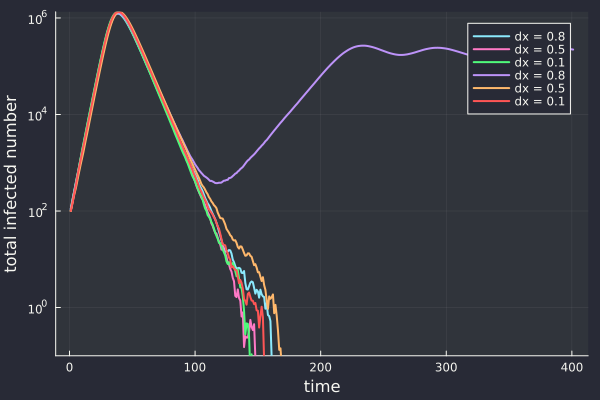

In [24]:
dx_values = [0.8, 0.5, 0.1]

# p2 = plot(xlabel = "time", ylabel="total infected number", yscale=:log10, ylim=(0.1, Inf))
for i in eachindex(dx_values)      
    # Parameters
    L = 40.0
    dx = dx_values[i]
    x = -L/2:dx:L/2-dx
    r = 3.0
    M = 15
    beta = 2.5
    alpha = 0.0
    gamma = 1.0
    D = 0.0025
    # D = 0.0
    Nh = 2 * 10^6
    stochastic = true
    sigma = 1.0

    # Initialize viral and immune densities
    viral_density = zeros(Float64, length(x))
    # viral_density[Int(round(length(x)/2))] = 100/dx

    initial_variance = 0.1
    viral_density .= 100/sqrt(2 * pi * initial_variance) .* exp.(-x.^2/2/initial_variance)
    immune_density = zeros(Float64, length(x))

    # Create Population instances
    population = Population(L, dx, r, M, beta, alpha, gamma, D, Nh, viral_density, immune_density;stochastic=stochastic, sigma=sigma)
    populations = [population]

    # populations[1] = Population(L, dx, r, M, beta, alpha, gamma, D, Nh, viral_density, immune_density;stochastic=true)

    # Create Network instance
    migration_matrix = 0.0 * ones(size(populations,1),size(populations,1)) # Define an appropriate migration matrix
    network = Network(populations, migration_matrix);

    # Create Simulation instance
    dt = 0.01 # Define an appropriate time step size
    duration = 80.0 # Define an appropriate simulation duration
    simulation = Simulation(network, dt, duration; thin_by=20);

    println("CFL:", D * dt / dx^2)
    @time run_simulation!(simulation);
    total_infected_per_deme = calculate_total_infected_per_deme(simulation)
    plot!(p2, total_infected_per_deme[1,:], lw=2, label="dx = $(dx)")
end
display(p2)

Lets do a few full runs to make sure this looks reasonable before pushing to the cluster

2
0.039999999999999994
  2.347682 seconds (16.00 k allocations: 99.610 MiB)
false


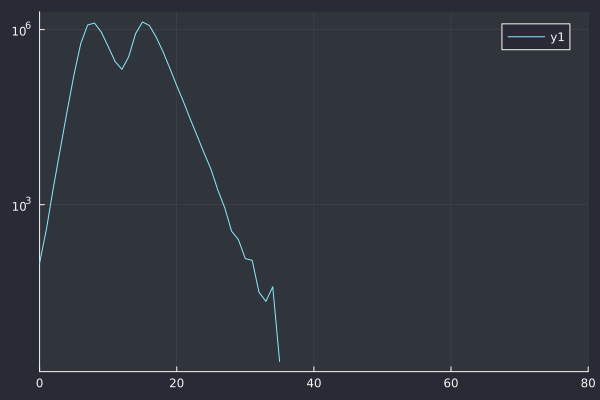

In [25]:
# Parameters
L = 40.0
dx = 0.05
x = -L/2:dx:L/2-dx
r = 3.0
M = 15
beta = 2.5
alpha = 0.0
gamma = 1.0
D = 0.01
Nh = 2 * 10^6
stochastic = true
sigma = sqrt(20)

# Initialize viral and immune densities
viral_density = zeros(Float64, length(x))
viral_density[Int(round(length(x)/2))] = 100/dx

# initial_variance = 0.1
# viral_density .= 100/sqrt(2 * pi * initial_variance) .* exp.(-x.^2/2/initial_variance)
viral_density2 = zeros(Float64, length(x))
immune_density = zeros(Float64, length(x))

# Create Population instances
population = Population(L, dx, r, M, beta, alpha, gamma, D, Nh, viral_density, immune_density;stochastic=stochastic, sigma=sigma)
population2 = Population(L, dx, r, M, beta, alpha, gamma, D, Nh, viral_density2, immune_density; stochastic=stochastic, sigma=sigma)
populations = [population, population2]

# populations[1] = Population(L, dx, r, M, beta, alpha, gamma, D, Nh, viral_density, immune_density;stochastic=true)

# Create Network instance
migration_matrix = 1e-5 * ones(size(populations,1),size(populations,1)) # Define an appropriate migration matrix
println(size(migration_matrix,1))
network = Network(populations, migration_matrix);

# Create Simulation instance
dt = 0.01 # Define an appropriate time step size
duration = 80.0 # Define an appropriate simulation duration
simulation = Simulation(network, dt, duration; thin_by=100);
println(dt * D / dx^2)
@time run_simulation!(simulation);

total_infected = calculate_total_infected(simulation)
println(total_infected_per_deme[1,end] > 0)

antigenic_variance_per_deme = calculate_antigenic_variance_per_deme(simulation)

region = total_infected .> 0
plot(simulation.duration_times[region], total_infected[region], yscale=:log10, xlims=(0, simulation.duration))

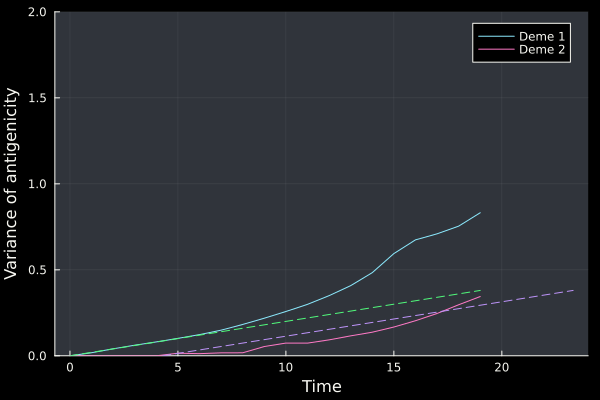

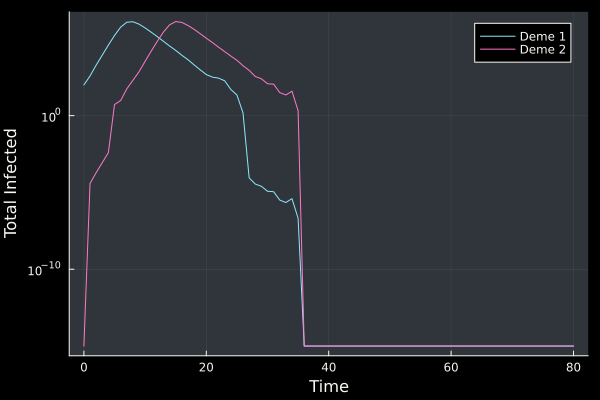

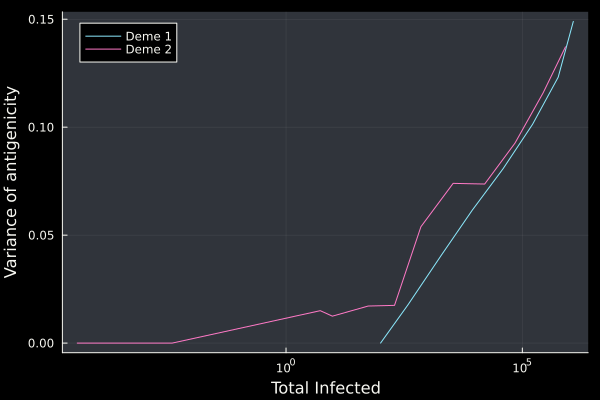

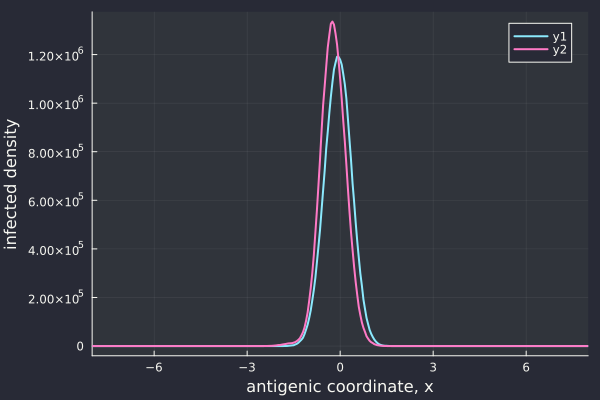

In [26]:
variances_per_deme = calculate_antigenic_variance_per_deme(simulation)
total_infected_per_deme = calculate_total_infected_per_deme(simulation)

# Number of demes
num_demes = size(total_infected_per_deme, 1)

# Plot for Variance of Antigenicity vs Time
treg = simulation.duration_times .< 20
p = plot(;xlabel="Time", ylabel="Variance of antigenicity", background_color=:black)
p2 = plot(xlabel="Time", ylabel="Total Infected", background_color=:black, yscale=:log, legend=:best)
p3 = plot(xlabel="Total Infected", ylabel="Variance of antigenicity", xscale=:log10, legend=:topleft, background_color=:black)


for deme in 1:num_demes
    plot!(p, simulation.duration_times[treg], variances_per_deme[deme, treg], label="Deme $deme")
end
plot!(p, simulation.duration_times[treg], 0.0 .+ 2 * D * simulation.duration_times[treg], linestyle=:dash, label=:none)
plot!(p, simulation.duration_times[treg] .+ 4.3, 2 * D * simulation.duration_times[treg], linestyle=:dash, label=:none)
plot!(p, ylim=(0,2))
display(p)

# Plot for Total Infected vs Time
treg = simulation.duration_times .< 90

# Manually setting y-axis ticks for each order of magnitude
# yticks = [10^i for i in 0:7]; plot!(p2, yticks=yticks)
for deme in 1:num_demes
    plot!(p2, simulation.duration_times[treg], total_infected_per_deme[deme, treg] .+ 10^-15, label="Deme $deme")
end
# plot!(p2, simulation.duration_times[treg] .- 4.3, total_infected_per_deme[2, treg] .+ 10^-15, label="Deme 2, shifted", xlim=(0,Inf))
display(p2)

for deme in 1:num_demes
    # Find the index where the total infected per deme attains its maximum for the first time
    max_index = findfirst(==(maximum(total_infected_per_deme[deme, :])), total_infected_per_deme[deme, :])

    # Create the Boolean mask
    # reg = (total_infected_per_deme[deme, :] .> 100) .& (variances_per_deme[deme, :] .> 0) .& (1:length(total_infected_per_deme[deme, :]) .< max_index)
    reg = (total_infected_per_deme[deme, :] .> 0) .& (simulation.duration_times .<  simulation.duration_times[argmax(total_infected_per_deme[deme, 1:50])])
    
    # Plot using the mask
    plot!(p3, total_infected_per_deme[deme, reg], variances_per_deme[deme, reg], label="Deme $deme")
end
display(p3)

p4 = plot(xlabel="antigenic coordinate, x", ylabel="infected density", xlims=(-8, 8))
t_max_1 = argmax(total_infected_per_deme[1,:])
t_max_2 = argmax(total_infected_per_deme[2,:])
plot!(p4, simulation.trajectory[t_max_1].populations[1].xs,
     simulation.trajectory[t_max_1].populations[1].viral_density, lw=2)
     
plot!(p4, simulation.trajectory[t_max_2].populations[2].xs,
     simulation.trajectory[t_max_2].populations[2].viral_density, lw=2)

Lets see how the noise amplitudes change for the two noise methods 

CFL:0.0
  0.010137 seconds (1.60 k allocations: 787.688 KiB)
CFL:0.0
  0.020668 seconds (1.60 k allocations: 1.135 MiB)
CFL:0.0
  0.123299 seconds (1.60 k allocations: 5.091 MiB)
CFL:0.0
  0.231273 seconds (1.60 k allocations: 9.973 MiB)
CFL:0.0
  5.351572 seconds (1.60 k allocations: 24.622 MiB)


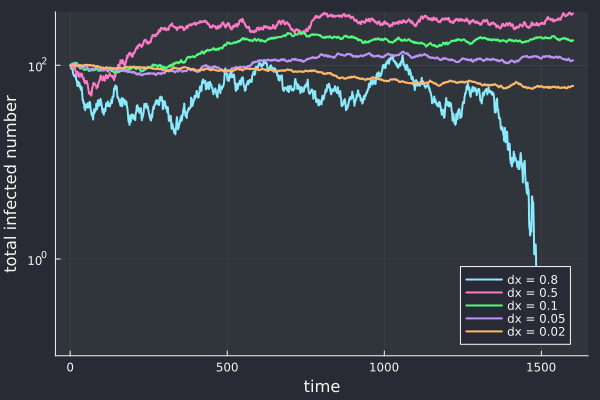

In [27]:
dx_values = [0.8, 0.5, 0.1, 0.05, 0.02]

p2 = plot(xlabel = "time", ylabel="total infected number", yscale=:log10, ylim=(0.1, Inf))
for i in eachindex(dx_values)    
    for j in 1:1  
        # Parameters
        L = 40.0
        dx = dx_values[i]
        x = -L/2:dx:L/2-dx
        r = 3.0
        M = 15
        beta = 0.0
        alpha = 0.0
        gamma = 0.0
        # D = 0.0025
        D = 0.0
        Nh = 2 * 10^6
        stochastic = true
        sigma = 2.0
        noise_method=:PL

        # Initialize viral and immune densities
        viral_density = zeros(Float64, length(x))
        # viral_density[Int(round(length(x)/2))] = 100/dx

        initial_variance = 0.3
        viral_density .= 100/sqrt(2 * pi * initial_variance) .* exp.(-x.^2/2/initial_variance)
        immune_density = zeros(Float64, length(x))

        # Create Population instances
        population = Population(L, dx, r, M, beta, alpha, gamma, D, Nh, viral_density, immune_density;stochastic=stochastic, sigma=sigma, noise_method=noise_method)
        populations = [population]

        # populations[1] = Population(L, dx, r, M, beta, alpha, gamma, D, Nh, viral_density, immune_density;stochastic=true)

        # Create Network instance
        migration_matrix = 0.0 * ones(size(populations,1),size(populations,1)) # Define an appropriate migration matrix
        network = Network(populations, migration_matrix);

        # Create Simulation instance
        dt = 0.05 # Define an appropriate time step size
        duration = 80.0 # Define an appropriate simulation duration
        simulation = Simulation(network, dt, duration; thin_by=1);

        println("CFL:", D * dt / dx^2)
        @time run_simulation!(simulation);
        total_infected_per_deme = calculate_total_infected_per_deme(simulation)
        plot!(p2, total_infected_per_deme[1,:], lw=2, label="dx = $(dx)",legend=:bottomright)
    end
end
display(p2)

CFL:0.0
  0.007764 seconds (1.60 k allocations: 787.688 KiB)
CFL:0.0
  0.014151 seconds (1.60 k allocations: 1.135 MiB)
CFL:0.0
  0.104860 seconds (1.60 k allocations: 5.091 MiB)
CFL:0.0
  0.212397 seconds (1.60 k allocations: 9.973 MiB)
CFL:0.0
  5.910007 seconds (1.60 k allocations: 24.622 MiB)


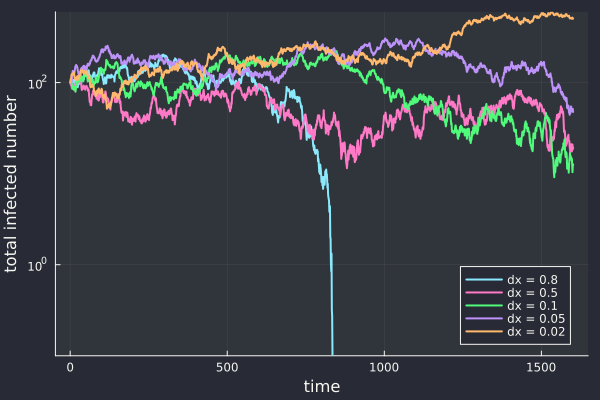

In [28]:
dx_values = [0.8, 0.5, 0.1, 0.05, 0.02]

p2 = plot(xlabel = "time", ylabel="total infected number", yscale=:log10, ylim=(0.1, Inf))
for i in eachindex(dx_values)    
    for j in 1:1  
        # Parameters
        L = 40.0
        dx = dx_values[i]
        x = -L/2:dx:L/2-dx
        r = 3.0
        M = 15
        beta = 0.0
        alpha = 0.0
        gamma = 0.0
        # D = 0.0025
        D = 0.0
        Nh = 2 * 10^6
        stochastic = true
        sigma = 2.0
        noise_method= :PL_with_dx

        # Initialize viral and immune densities
        viral_density = zeros(Float64, length(x))
        # viral_density[Int(round(length(x)/2))] = 100/dx

        initial_variance = 0.3
        viral_density .= 100/sqrt(2 * pi * initial_variance) .* exp.(-x.^2/2/initial_variance)
        immune_density = zeros(Float64, length(x))

        # Create Population instances
        population = Population(L, dx, r, M, beta, alpha, gamma, D, Nh, viral_density, immune_density;stochastic=stochastic, sigma=sigma, noise_method=noise_method)
        populations = [population]

        # populations[1] = Population(L, dx, r, M, beta, alpha, gamma, D, Nh, viral_density, immune_density;stochastic=true)

        # Create Network instance
        migration_matrix = 0.0 * ones(size(populations,1),size(populations,1)) # Define an appropriate migration matrix
        network = Network(populations, migration_matrix);

        # Create Simulation instance
        dt = 0.05 # Define an appropriate time step size
        duration = 80.0 # Define an appropriate simulation duration
        simulation = Simulation(network, dt, duration; thin_by=1);

        println("CFL:", D * dt / dx^2)
        @time run_simulation!(simulation);
        total_infected_per_deme = calculate_total_infected_per_deme(simulation)
        plot!(p2, total_infected_per_deme[1,:], lw=2, label="dx = $(dx)",legend=:bottomright)
    end
end
display(p2)

In [29]:
population.sigma

2.0